# Data exploration

Data exploration of ADNI patients. The data consists of features derived from T1 weighted images of patients in their first MRI visit in each phase of the program. The features were extracted using SIENAX to determine tissue types and FIRST to determine subcortical structure volumes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_ind, kruskal

### Data merging

In [2]:
def process_df(phase):
    # Load data
    df_features = pd.read_table('../DATA/processed_data_adni%d.tsv'%phase, sep=' ').dropna()
    df_patient_list = pd.read_table('../DATA/participants_adni%d.tsv'%phase, names=['Subject', 'PTID'])
    df_metadata = pd.read_csv('../DATA/adni%d_mri.csv'%phase, index_col=0)
    
    # Combine left and right structures to single structure
    structures = ['Thalmus', 'Caudate', 'Putamen', 'Palidum', 
            'Hippo', 'Amygdala', 'Accumbens']
    for s in structures:
        df_features[s] = df_features['L_%s'%s]+df_features['R_%s'%s]
    
    df_full = df_patient_list.merge(df_features, on='Subject').merge(df_metadata, on='PTID')
                                                                 
    # Remove sites that do not contain alzeihmers patient
    all_sites = set(df_full['SITEID'])
    ad_sites = set(df_full[df_full['DIAGNOSIS']==3.0]['SITEID'])
    missing_sites = [site for site in all_sites if site not in ad_sites]
    df_full = df_full[df_full['SITEID'].isin(missing_sites) == False]
    
    # Get back non-normalized (raw features)
    for f in ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm']:
        df_full[f] = df_full[f]/df_full['Vscale']

    # Change gender and phase assigment
    df_full['PTGENDER'].replace(['Female','Male'],[0,1],inplace=True)
    df_full['Phase'].replace(['ADNI2','ADNI3'],[0,1],inplace=True)

    return df_full

# Create dataframes for each phase
df_full_adni2 = process_df(2)
df_full_adni3 = process_df(3)

# Concatenate dataframes
pd.set_option('display.max_columns', None)
df_full = pd.concat([df_full_adni2, df_full_adni3], ignore_index=True)
df_full = df_full.drop_duplicates('RID', keep='first') # keep ADNI2 if duplciates

### Site analysis

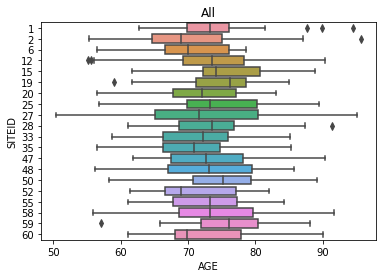

In [3]:
# Show age distribution by site
plt.figure()
plt.title('All')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full, orient='h')
plt.show()

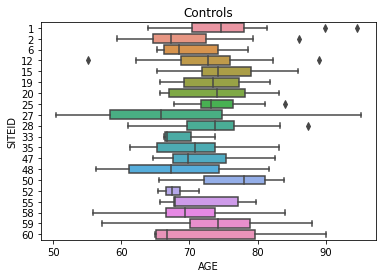

In [4]:
# Show age distribution by site
plt.figure()
plt.title('Controls')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==1.0], orient='h')
plt.show()

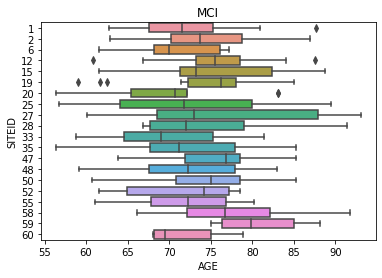

In [5]:
# Show age distribution by site
plt.figure()
plt.title('MCI')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==2.0], orient='h')
plt.show()

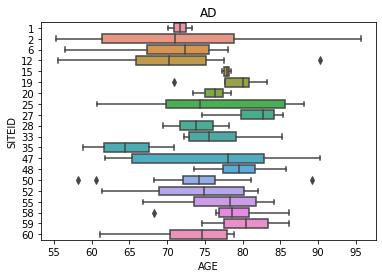

In [6]:
# Show age distribution by site
plt.figure()
plt.title('AD')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==3.0], orient='h')
plt.show()

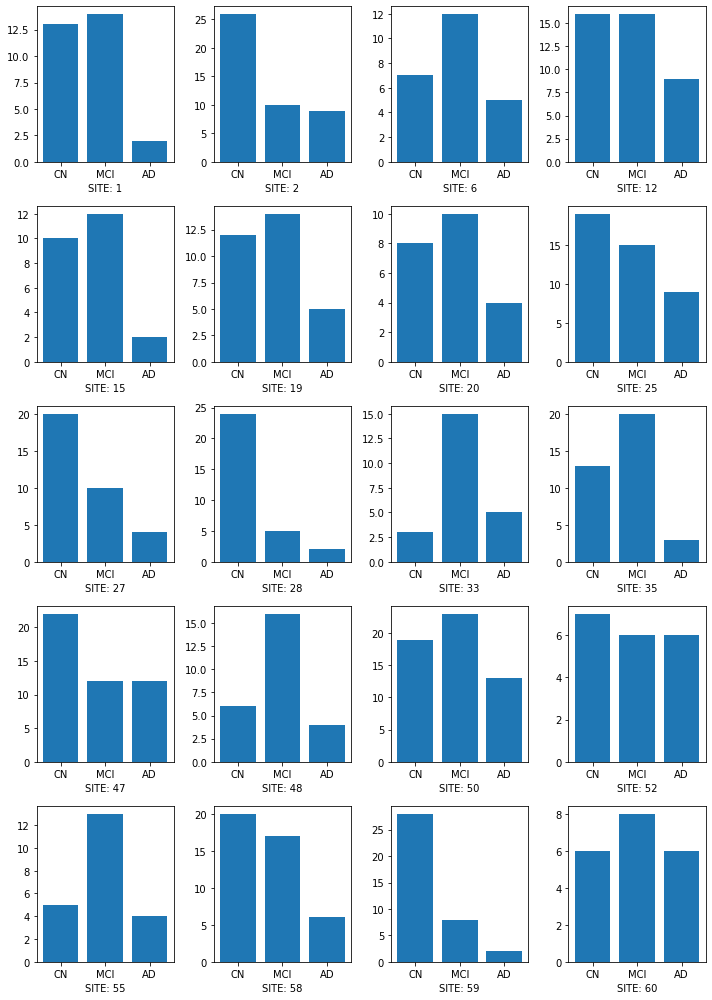

In [7]:
plt.figure(figsize=(10,14))
names = ['CN', 'MCI', 'AD']
sites = set(df_full['SITEID'])
for i, site in enumerate(sites):
    # Explor variability of features by site
    plt.subplot(5,4,i+1)
    df_site = df_full[df_full['SITEID']==site]
    vals = [np.sum(df_site['DIAGNOSIS']==diag) for diag in [1.0, 2.0, 3.0]]
    plt.bar(names, vals)
    plt.xlabel('SITE: %d' %site)
    plt.tight_layout()

### Analysis on control

In [8]:
# Exctract controls that haven't converted
df_controls = df_full[df_full['TYPECONVERSOR']==1.0]

# Mark features to use
features = ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm', 'Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens', 'Brainstem']

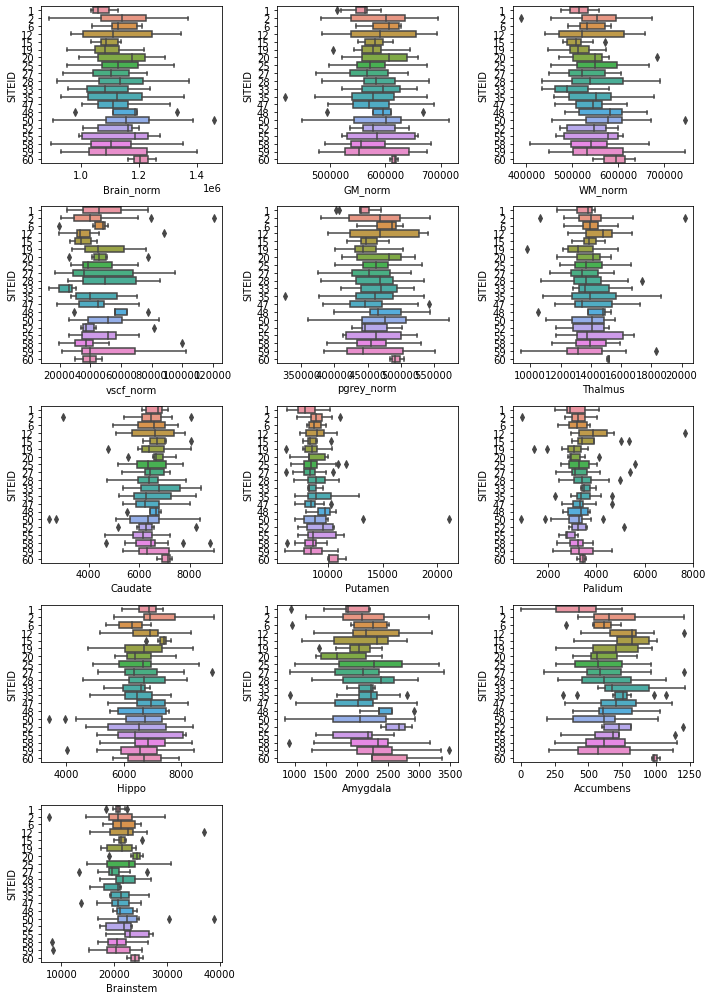

In [9]:
# Explor variability of features by site
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_controls, orient='h')
    plt.tight_layout()

In [10]:
# Data harmonization with Combat
from pycombat import Combat
combat = Combat()
Y = df_controls[features].to_numpy()
b = df_controls['SITEID'].to_numpy()
X = df_controls['AGE'].to_numpy()[:, np.newaxis]
C = df_controls[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
y_adjusted = combat.fit_transform(Y=Y, b=b, X=X, C=C)

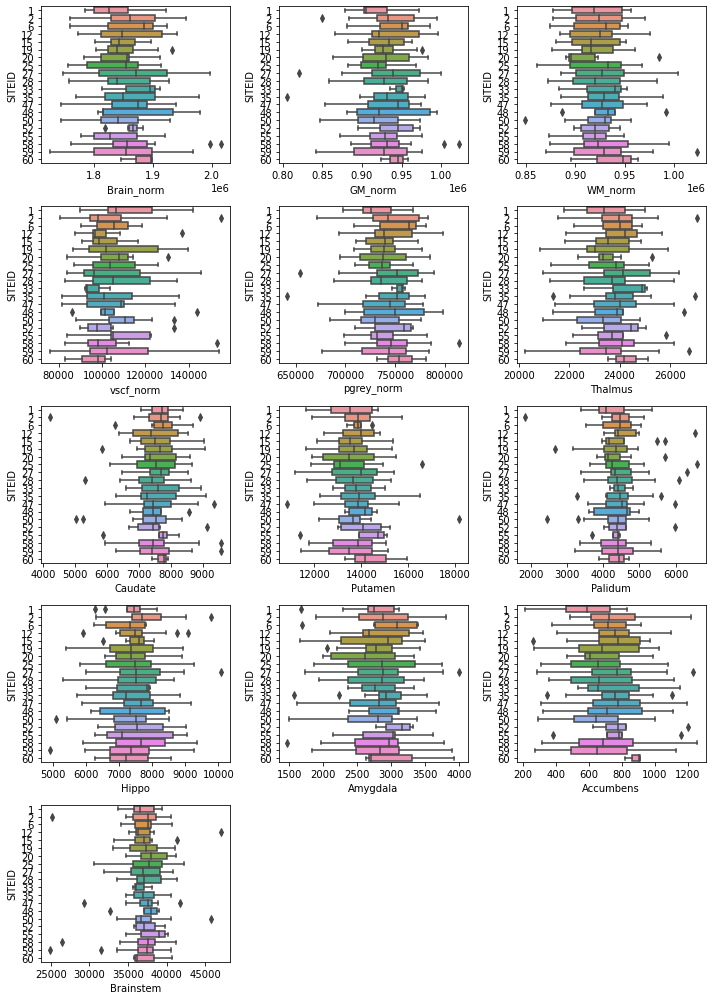

In [11]:
# Explor variability of features by site after harmonization
df_features_harm = pd.DataFrame(data=y_adjusted, columns=features)
df_features_harm['SITEID'] = df_controls['SITEID'].reset_index(drop=True)
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_features_harm, orient='h')
    plt.tight_layout()

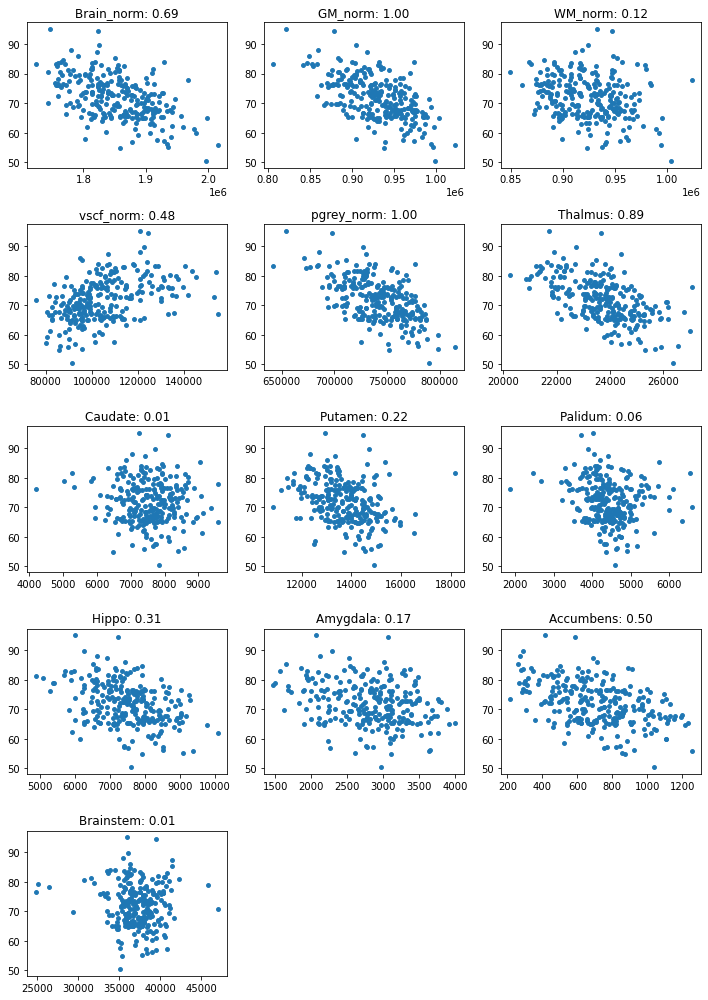

In [12]:
from sklearn.feature_selection import f_regression

X = df_features_harm[features].to_numpy()
Y = df_controls['AGE'].to_numpy()

f_test, _ = f_regression(X, Y)
f_test /= np.max(f_test) # We normalize beacuse we are interested in relative values

plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X[:,d],Y,s=15)
    plt.title("{0}: {1:.2f}".format(features[d],f_test[d]))
plt.tight_layout()

In [13]:
# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train_norm = transformer.transform(X_train) # transform() normalizes
X_test_norm =  transformer.transform(X_test)

MAE in test: 4.132397


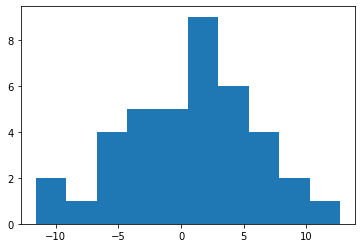

In [14]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression(fit_intercept='True')
# Train the model
LR.fit(X_train_norm, Y_train)

# Compute the predictions over test data
f_test = LR.predict(X_test_norm)
errors = Y_test-f_test
MAE_test = np.mean(np.abs(errors))
print('MAE in test: %f' % MAE_test)
plt.hist(errors)
plt.show()

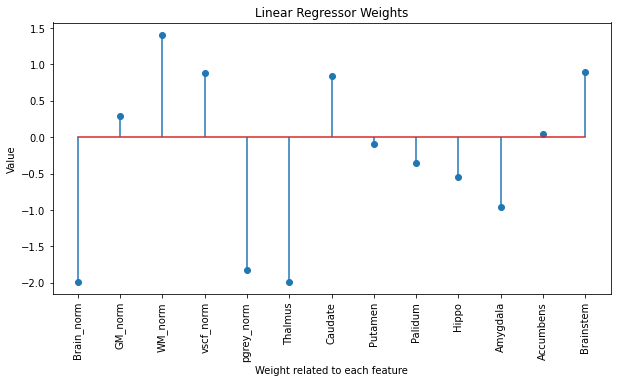

In [15]:
# Linear regressor weights as a guide for selection of the range of alpha
LR_weights = LR.coef_

# Plot weights
plt.figure(figsize=(10,5))
plt.title('Linear Regressor Weights')
plt.stem(features, LR_weights)
plt.xticks(rotation='vertical')
plt.xlabel('Weight related to each feature')
plt.ylabel('Value')
plt.show()

The sign of the weights might not agree with those shown in the correlation analysis because in the correlation analysis we are only taking into account the relationship between the dependendent variable and each variable individiually. Whereas the indepedent variables can be correlated between them and so for example compensate each other since for example pgrey_norm is heavly correlated with GM_norm.

In [16]:
# Performance evaluation of Ridge Regressor with Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Variables
alpha_values_ridge = np.logspace(-2, 3, num=30)
tuned_parameters_ridge = [{'alpha': alpha_values_ridge}]
nfold = 5

# Create pipeline (Creatue poly features, normalize features, use these to train model)
steps = [('poly', PolynomialFeatures()), ('normalize', StandardScaler()), ('clf', Ridge())]
pipe_Ridge = Pipeline(steps)

# Do not include a bias term when creating features
pipe_Ridge.set_params(poly__include_bias=False)
# Make sure the bias is fit
pipe_Ridge.set_params(clf__fit_intercept=True)

# CV range of values to check
param_grid_Ridge = dict(poly__degree=[1, 2, 3], clf__alpha = alpha_values_ridge)

# Create CV grid search
pipe_grid_search_Ridge = GridSearchCV(pipe_Ridge, param_grid=param_grid_Ridge, cv=nfold, scoring='neg_mean_squared_error')
# No need to feed normalized data as it will be normalized in the pipeline
pipe_grid_search_Ridge.fit(X_train, Y_train)

# Optimum hyperparameter values
PolyRidge_degree_opt = pipe_grid_search_Ridge.best_params_['poly__degree']
print('Optimum value of polynomial degree is %d' % PolyRidge_degree_opt)
PolyRidge_alpha_opt = pipe_grid_search_Ridge.best_params_['clf__alpha']
print('Optimum value of alpha is %.2f' % PolyRidge_alpha_opt)

# Compute the predictions over train and test data
PolyRidge_f_train = pipe_grid_search_Ridge.predict(X_train)
PolyRidge_f_test = pipe_grid_search_Ridge.predict(X_test)

# Calculate MSE for both train and test
PolyRidge_MAE_train = metrics.mean_absolute_error(Y_train, PolyRidge_f_train)
PolyRidge_MAE_test = metrics.mean_absolute_error(Y_test, PolyRidge_f_test)

# Show result
print("The trained Ridge regressor with polynomial features has an MSE for the training data of: %.2f" % PolyRidge_MAE_train)
print("The trained Ridge regressor with polynomial features has an MSE for the test data of: %.2f" % PolyRidge_MAE_test)

Optimum value of polynomial degree is 3
Optimum value of alpha is 92.37
The trained Ridge regressor with polynomial features has an MSE for the training data of: 3.89
The trained Ridge regressor with polynomial features has an MSE for the test data of: 4.46


In [17]:
# Performance evaluation of weighted KNN
from sklearn.neighbors import KNeighborsRegressor

# Define tuned_parameters
rang_K = range(1, 21)
tuned_parameters_kNN  = dict(kNN__n_neighbors = rang_K)

# Create pipeline and ensure neighbours are weighted by the inverse of their distance
pipe_WkNN = Pipeline([('scaler', StandardScaler()), ('kNN', KNeighborsRegressor(weights='distance'))])

# Create a gridSearch over the pipeline
pipe_grid_search_WkNN = GridSearchCV(pipe_WkNN, tuned_parameters_kNN, cv=nfold, scoring='neg_mean_squared_error')

# Train
pipe_grid_search_WkNN.fit(X_train, Y_train)

# Optimum hyperparameter values
Weighted_KNN_neighbors_opt = pipe_grid_search_WkNN.best_params_['kNN__n_neighbors']
print('Optimum value of neighbors is %d' %Weighted_KNN_neighbors_opt)


# Compute the predictions over train and test data
Weighted_KNN_f_train = pipe_grid_search_WkNN.predict(X_train)
Weighted_KNN_f_test = pipe_grid_search_WkNN.predict(X_test)

# Calculate MSE for both train and test
Weighted_KNN_MAE_train = metrics.mean_absolute_error(Y_train, Weighted_KNN_f_train)
Weighted_KNN_MAE_test = metrics.mean_absolute_error(Y_test, Weighted_KNN_f_test)

# Show result
print("The trained kNN has an MSE for the training data of: %.2f" % Weighted_KNN_MAE_train)
print("The trained kNN has an MSE for the test data of: %.2f" % Weighted_KNN_MAE_test)

Optimum value of neighbors is 15
The trained kNN has an MSE for the training data of: 0.00
The trained kNN has an MSE for the test data of: 5.09


/Users/jorgegarciacondado/opt/anaconda3/envs/adni/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


MAE in test: 4.046520


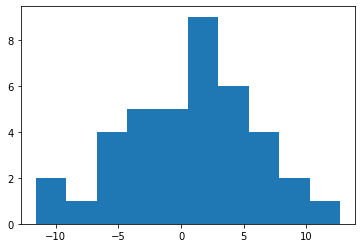

In [18]:
# Generate Sklearn Gradient Boosting Classifier
import xgboost as xgb
xgbR= xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=7,
                       subsample=0.1, learning_rate=0.1)
    
# Train
xgbR.fit(X_train_norm, Y_train)

# Compute the predictions over test data
f_test_xgbr = xgbR.predict(X_test_norm)
errors_xgbr = Y_test-f_test_xgbr
MAE_test_xgbr = np.mean(np.abs(errors_xgbr))
print('MAE in test: %f' % MAE_test_xgbr)
plt.hist(errors)
plt.show()

No real improvement in any of the more complex models so following occam's razor the linear regressor is the best to follow for further analysis.

### Analysis of brain deltas

In [19]:
# Harmonize all data
Y = df_full[features].to_numpy()
b = df_full['SITEID'].to_numpy()
X = df_full['AGE'].to_numpy()[:, np.newaxis]
C = df_full[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
y_adjusted = combat.transform(Y=Y, b=b, X=X, C=C)
X_norm = transformer.transform(y_adjusted) 
df_full['PredBrainAge'] = LR.predict(X_norm)
df_full['BrainDelta'] = df_full['PredBrainAge']-df_full['AGE']

In [20]:
# Cohen's d size: 0.01 Very small, 0.2 Small, 0.5 Medium, 0.8 Large, 1.2 Very large, 2.0 Huge
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

Brain delta mean for
CN: 0.647899
MCI: 2.344333
AD: 6.445599
Brain delta median for
CN: 0.780875
MCI: 1.869222
AD: 5.282464
p-value
CN vs MCI: 0.170234
CN vs AD: 0.000271
MCI vs AD: 0.000008
Cohens d
CN vs MCI: -0.263883
CN vs AD: -0.775055
MCI vs AD: 0.491145


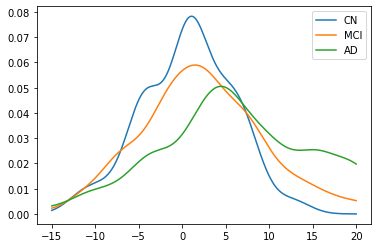

In [21]:
# Explore difference between CN, MCI and AD
df_mci = df_full[df_full['DIAGNOSIS']==2.0]
df_ad = df_full[df_full['DIAGNOSIS']==3.0]

# Make estimations
delta_brain_controls = errors
delta_brain_mci = df_mci['BrainDelta'].to_numpy()
delta_brain_ad = df_ad['BrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_brain_controls))
print('MCI: %f' % np.mean(delta_brain_mci))
print('AD: %f' % np.mean(delta_brain_ad))
print('Brain delta median for')
print('CN: %f' % np.median(delta_brain_controls))
print('MCI: %f' % np.median(delta_brain_mci))
print('AD: %f' % np.median(delta_brain_ad))

# Calculate p-value
print('p-value')
tstat_cnvsmci, pval_cnvsmci = ttest_ind(delta_brain_controls, delta_brain_mci)
tstat_cnvsad, pval_cnvsad = ttest_ind(delta_brain_controls, delta_brain_ad)
tstat_mcivsad, pval_mcivsad = ttest_ind(delta_brain_ad, delta_brain_mci)
print('CN vs MCI: %f' % pval_cnvsmci)
print('CN vs AD: %f' % pval_cnvsad)
print('MCI vs AD: %f' % pval_mcivsad)

# Calculate cohen's d size
print('Cohens d')
cohend_cnvsmci = cohen_d(delta_brain_controls, delta_brain_mci)
cohend_cnvsad = cohen_d(delta_brain_controls, delta_brain_ad)
cohend_mcivsad = cohen_d(delta_brain_ad, delta_brain_mci)
print('CN vs MCI: %f' % cohend_cnvsmci)
print('CN vs AD: %f' % cohend_cnvsad)
print('MCI vs AD: %f' % cohend_mcivsad)

# Plot kernel density estimates for samples
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(-15, 20, 1000)[:, np.newaxis]
kde_cn = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_controls[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='AD')
plt.legend()
plt.show()

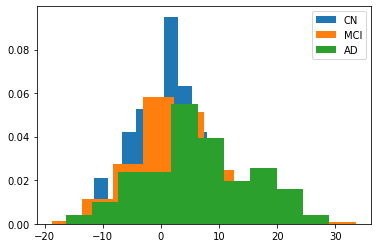

In [22]:
plt.hist(delta_brain_controls, label='CN', density=True)
plt.hist(delta_brain_mci, label='MCI', density=True)
plt.hist(delta_brain_ad, label='AD', density=True)
plt.legend()
plt.show()

Brain delta mean for
CN: 0.647899
CN2MCI: 0.555479
Brain delta median for
CN: 0.780875
CN2MCI: 0.787988
p-value
CN vs CN2MCI: 0.948684
Cohens d
CN vs CN2MCI: 0.017446


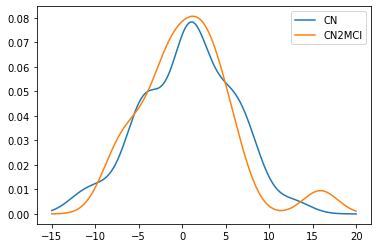

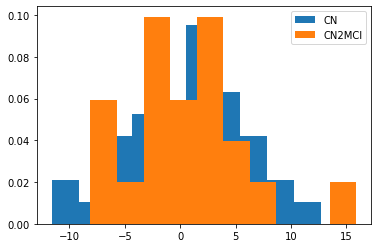

In [23]:
# Explore differences between CN and CN2MCI conversors
df_cn2mci = df_full[df_full['TYPECONVERSOR']==4.0]
delta_brain_cn2mci = df_cn2mci['BrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_brain_controls))
print('CN2MCI: %f' % np.mean(delta_brain_cn2mci))
print('Brain delta median for')
print('CN: %f' % np.median(delta_brain_controls))
print('CN2MCI: %f' % np.median(delta_brain_cn2mci))

# Calculate p-value
print('p-value')
tstat_cn2mci, pval_cn2mci = ttest_ind(delta_brain_controls, delta_brain_cn2mci)
print('CN vs CN2MCI: %f' % pval_cn2mci)

# Calculate cohen's d size
print('Cohens d')
cohend_cn2mci = cohen_d(delta_brain_controls, delta_brain_cn2mci)
print('CN vs CN2MCI: %f' % cohend_cn2mci)

# Plot kernel densities
kde_cn = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_controls[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_cn2mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='CN2MCI')
plt.legend()
plt.show()

# Plot histogram
plt.hist(delta_brain_controls, label='CN', density=True)
plt.hist(delta_brain_cn2mci, label='CN2MCI', density=True)
plt.legend()
plt.show()

Brain delta mean for
MCI: 1.663386
MCI2AD: 4.397637
Brain delta median for
MCI: 1.222115
MCI2AD: 3.326793
p-value
MCI vs MCI2AD: 0.010943
Cohens d
MCI vs MCI2AD: -0.375783


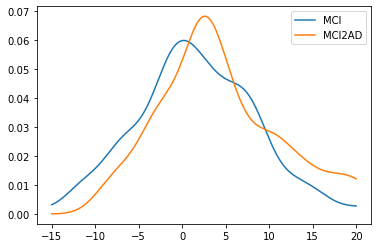

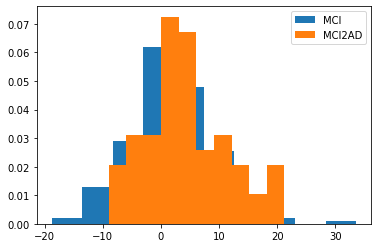

In [24]:
# Explore differences between MCI and CN2MCI conversors
df_mci = df_full[df_full['TYPECONVERSOR']==2.0]
df_mci2ad = df_full[df_full['TYPECONVERSOR']==5.0]
delta_brain_mci2ad = df_mci2ad['BrainDelta'].to_numpy()
delta_brain_mci = df_mci['BrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('MCI: %f' % np.mean(delta_brain_mci))
print('MCI2AD: %f' % np.mean(delta_brain_mci2ad))
print('Brain delta median for')
print('MCI: %f' % np.median(delta_brain_mci))
print('MCI2AD: %f' % np.median(delta_brain_mci2ad))

# Calculate t-test
print('p-value')
tstat_mci2ad, pval_mci2ad = ttest_ind(delta_brain_mci, delta_brain_mci2ad)
print('MCI vs MCI2AD: %f' % pval_mci2ad)

# Calculate cohen's d size
print('Cohens d')
cohend_mci2ad = cohen_d(delta_brain_mci, delta_brain_mci2ad)
print('MCI vs MCI2AD: %f' % cohend_mci2ad)

# Plot kernel density estimates
kde_mci = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=2).fit(delta_brain_mci2ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='MCI2AD')
plt.legend()
plt.show()

# Plot histograms
plt.hist(delta_brain_mci, label='MCI', density=True)
plt.hist(delta_brain_mci2ad, label='MCI2AD', density=True)
plt.legend()
plt.show()